In [37]:
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tms.utils.utils import load_results
from tms.training.experiments import run_experiments
from tms.llc import estimate_llc, get_llc_data
import os

In [42]:
version = "1.9.0"
data_path = "../data"
results = load_results(data_path, version)

# llc_estimates = estimate_llc(results, version)
llc_estimates = get_llc_data(results, version, data_path)

In [40]:
version = "1.7.0"
data_path = "../data"
results2 = load_results(data_path, version)

# llc_estimates = estimate_llc(results, version)
llc_estimates2 = get_llc_data(results, version, data_path)

In [41]:
llc_estimates["index"].values

array([  0,   0,   0, ..., 449, 449, 449])

In [74]:
def compare_dataframes_and_results(df_results_pairs, positions = [9, 18, 27, 36, -1], hyperparam_combos = [(300, 0.001)], x_scale="linear", y_scale="linear", sharey=False, sharex=False, ymin=1e-4):
    warnings.simplefilter(action='ignore', category=UserWarning)  # Probably unwise

    for batch_size, learning_rate in hyperparam_combos:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}\n")
        
        for position in positions:
            fig, axes = plt.subplots(1, len(df_results_pairs), figsize=(15*len(df_results_pairs), 10), sharey=sharey, sharex=sharex)
            if len(df_results_pairs) == 1:
                axes = [axes]

            for pair_index, (llc_estimates, results) in enumerate(df_results_pairs):
                llc_loss_by_sparsity = defaultdict(list)
                steps = results[0]['parameters']['log_ivl']
                
                for index in range(len(results)):
                    filtered_df = llc_estimates[llc_estimates['index'] == index]
                    llc = filtered_df[
                        (filtered_df['batch_size'] == batch_size) &
                        (filtered_df['lr'] == learning_rate) &
                        (filtered_df['snapshot_index'] == position) &
                        (filtered_df['t_sgld'] > 150) &
                        (filtered_df['llc_type'] != "mean")
                    ]["llc"].mean()
                    
                    loss = results[index]['logs']['loss'].values[position]
                    sparsity = results[index]['parameters']['sparsity']
                    llc_loss_by_sparsity[sparsity].append((llc, loss))

                for sparsity, llc_loss in llc_loss_by_sparsity.items():
                    if sparsity == 0:
                        continue
                    llcs = [llc for llc, loss in llc_loss if not(np.isnan(llc))]
                    losses = [loss for llc, loss in llc_loss if not(np.isnan(llc))]
                    if all(np.isnan(llc) for llc in llcs):
                        continue
                    axes[pair_index].scatter(*zip(*llc_loss), label=f"Sparsity: {round(sparsity,3)}")
                    if pair_index == 0:
                        title = "Initialized at random 4-gon"
                    if pair_index == 1:
                        title = "Initialized at optimal parameters for sparse inputs"
                    axes[pair_index].set_title(f"Pair {title}, Position {position}")
                    axes[pair_index].set_xlabel("LLC")
                    axes[pair_index].set_ylabel("Loss")
                    axes[pair_index].legend()
                    axes[pair_index].set_xscale(x_scale)
                    axes[pair_index].set_yscale(y_scale)
                    axes[pair_index].set_ylim(ymin=ymin)


            plt.tight_layout()
            plt.suptitle(f"Loss and LLC After Epoch {steps[position]}", fontsize=16)
            plt.subplots_adjust(top=0.9)
            #plt.savefig(f'../results/loss_vs_llc_epoch_{steps[position]}')
            plt.show()

In [64]:
llc_estimates

,Unnamed: 0,llc,llc/std,batch_size,lr,t_sgld,llc_type,loss,snapshot_index,index
0,0,-3.135006e-07,0.000001,300,0.001,0,mean,0.369723,9,0
1,1,-1.567503e-06,NaN,300,0.001,0,0,0.369723,9,0
2,2,0.000000e+00,NaN,300,0.001,0,1,0.369723,9,0
3,3,0.000000e+00,NaN,300,0.001,0,2,0.369723,9,0
4,4,-1.567503e-06,NaN,300,0.001,0,3,0.369723,9,0
...,...,...,...,...,...,...,...,...,...,...
6752995,2995,-1.168908e+00,NaN,300,0.001,499,0,0.006702,18,449
6752996,2996,-4.105435e-01,NaN,300,0.001,499,1,0.021120,18,449
6752997,2997,-9.568308e-01,NaN,300,0.001,499,2,0.010734,18,449
6752998,2998,1.340423e+00,NaN,300,0.001,499,3,0.054411,18,449


In [72]:
llc_estimates2

,Unnamed: 0,llc,llc/std,batch_size,lr,t_sgld,llc_type,loss,snapshot_index,index
0,0,0.000000,0.0,300,0.001,0,mean,1.000000,18,0
1,1,0.000000,NaN,300,0.001,0,0,1.000000,18,0
2,2,0.000000,NaN,300,0.001,0,1,1.000000,18,0
3,3,0.000000,NaN,300,0.001,0,2,1.000000,18,0
4,4,0.000000,NaN,300,0.001,0,3,1.000000,18,0
...,...,...,...,...,...,...,...,...,...,...
6749995,2995,3.495136,NaN,300,0.001,499,0,0.066463,27,449
6749996,2996,1.838221,NaN,300,0.001,499,1,0.034961,27,449
6749997,2997,2.579623,NaN,300,0.001,499,2,0.049057,27,449
6749998,2998,1.626915,NaN,300,0.001,499,3,0.030943,27,449


In [73]:
high_sparsity = llc_estimates[llc_estimates['index'] >= 400]
high_sparsity2 = llc_estimates2[llc_estimates2['index'] >= 400]

Batch size: 300, Learning rate: 0.001



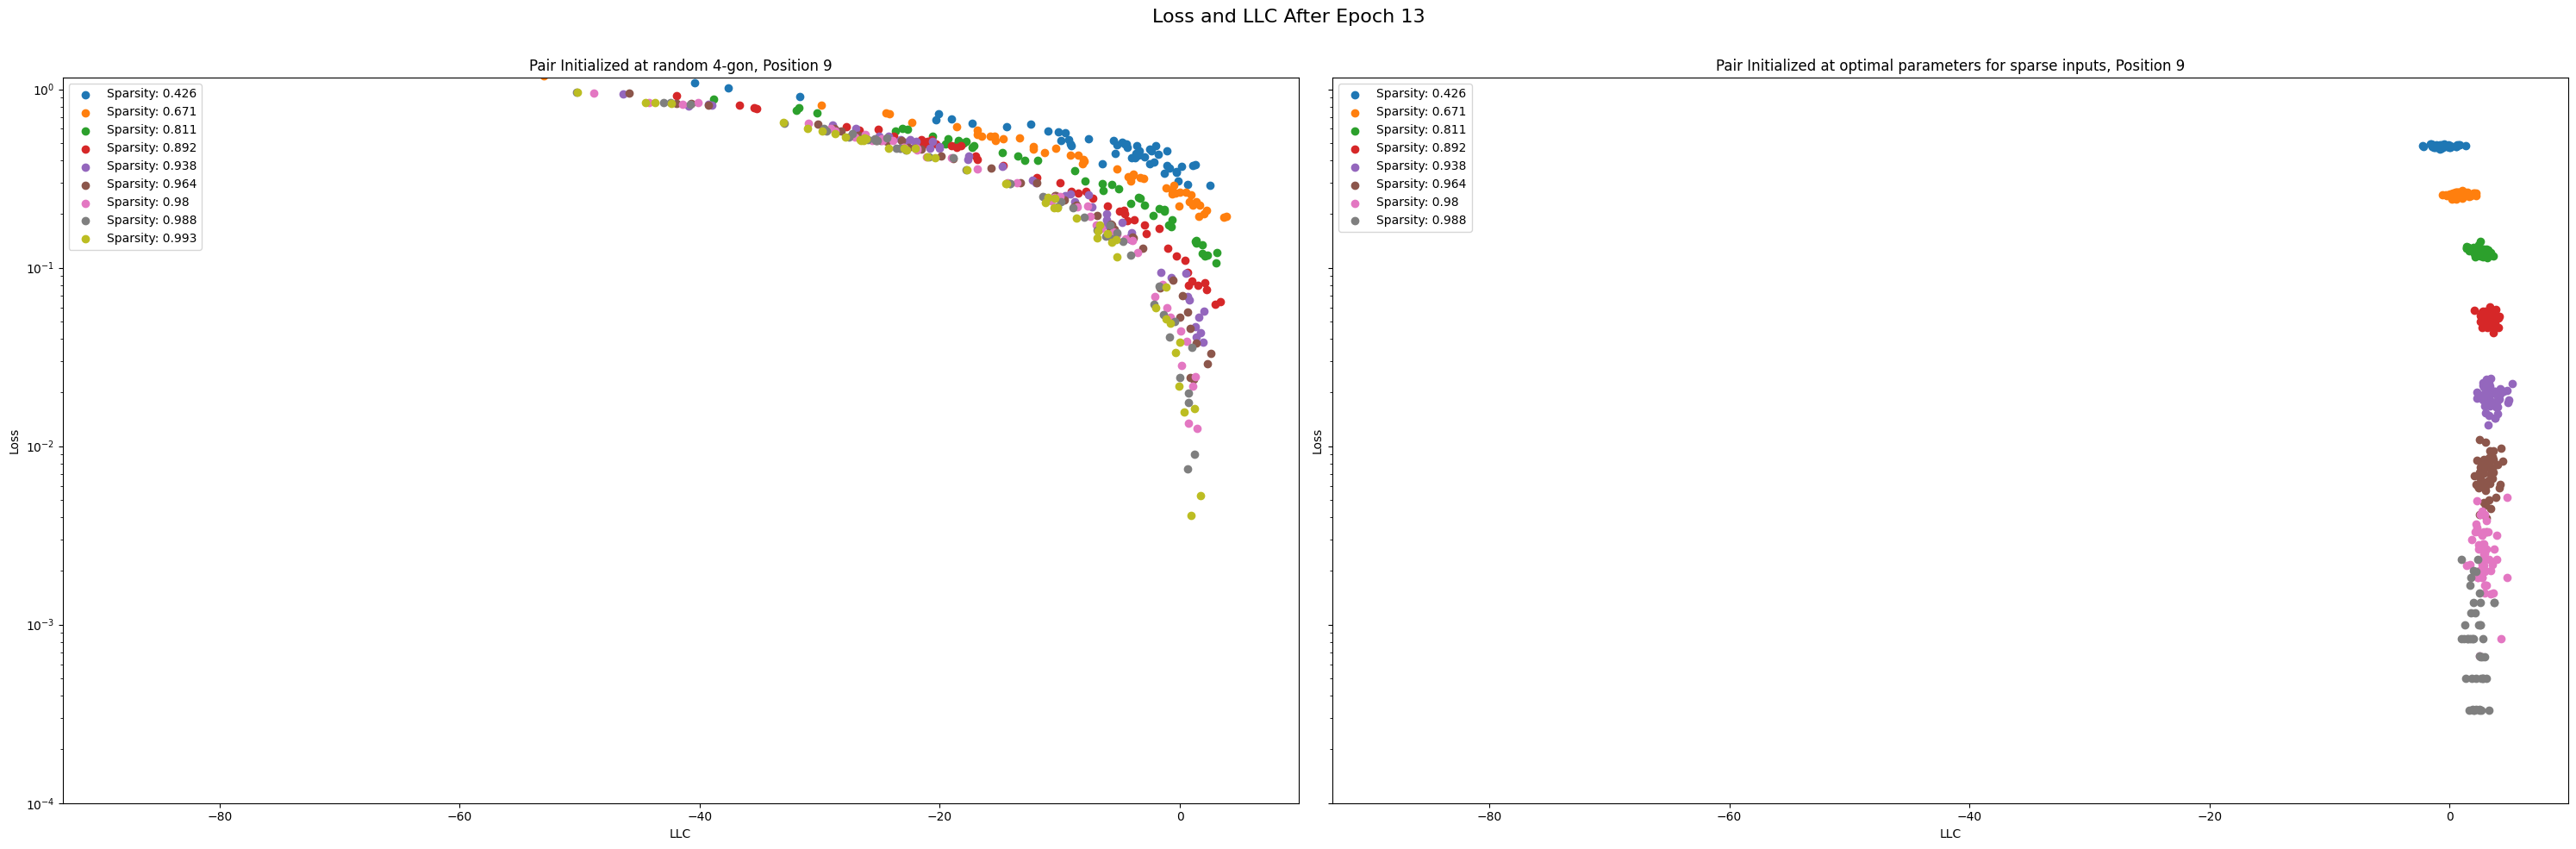

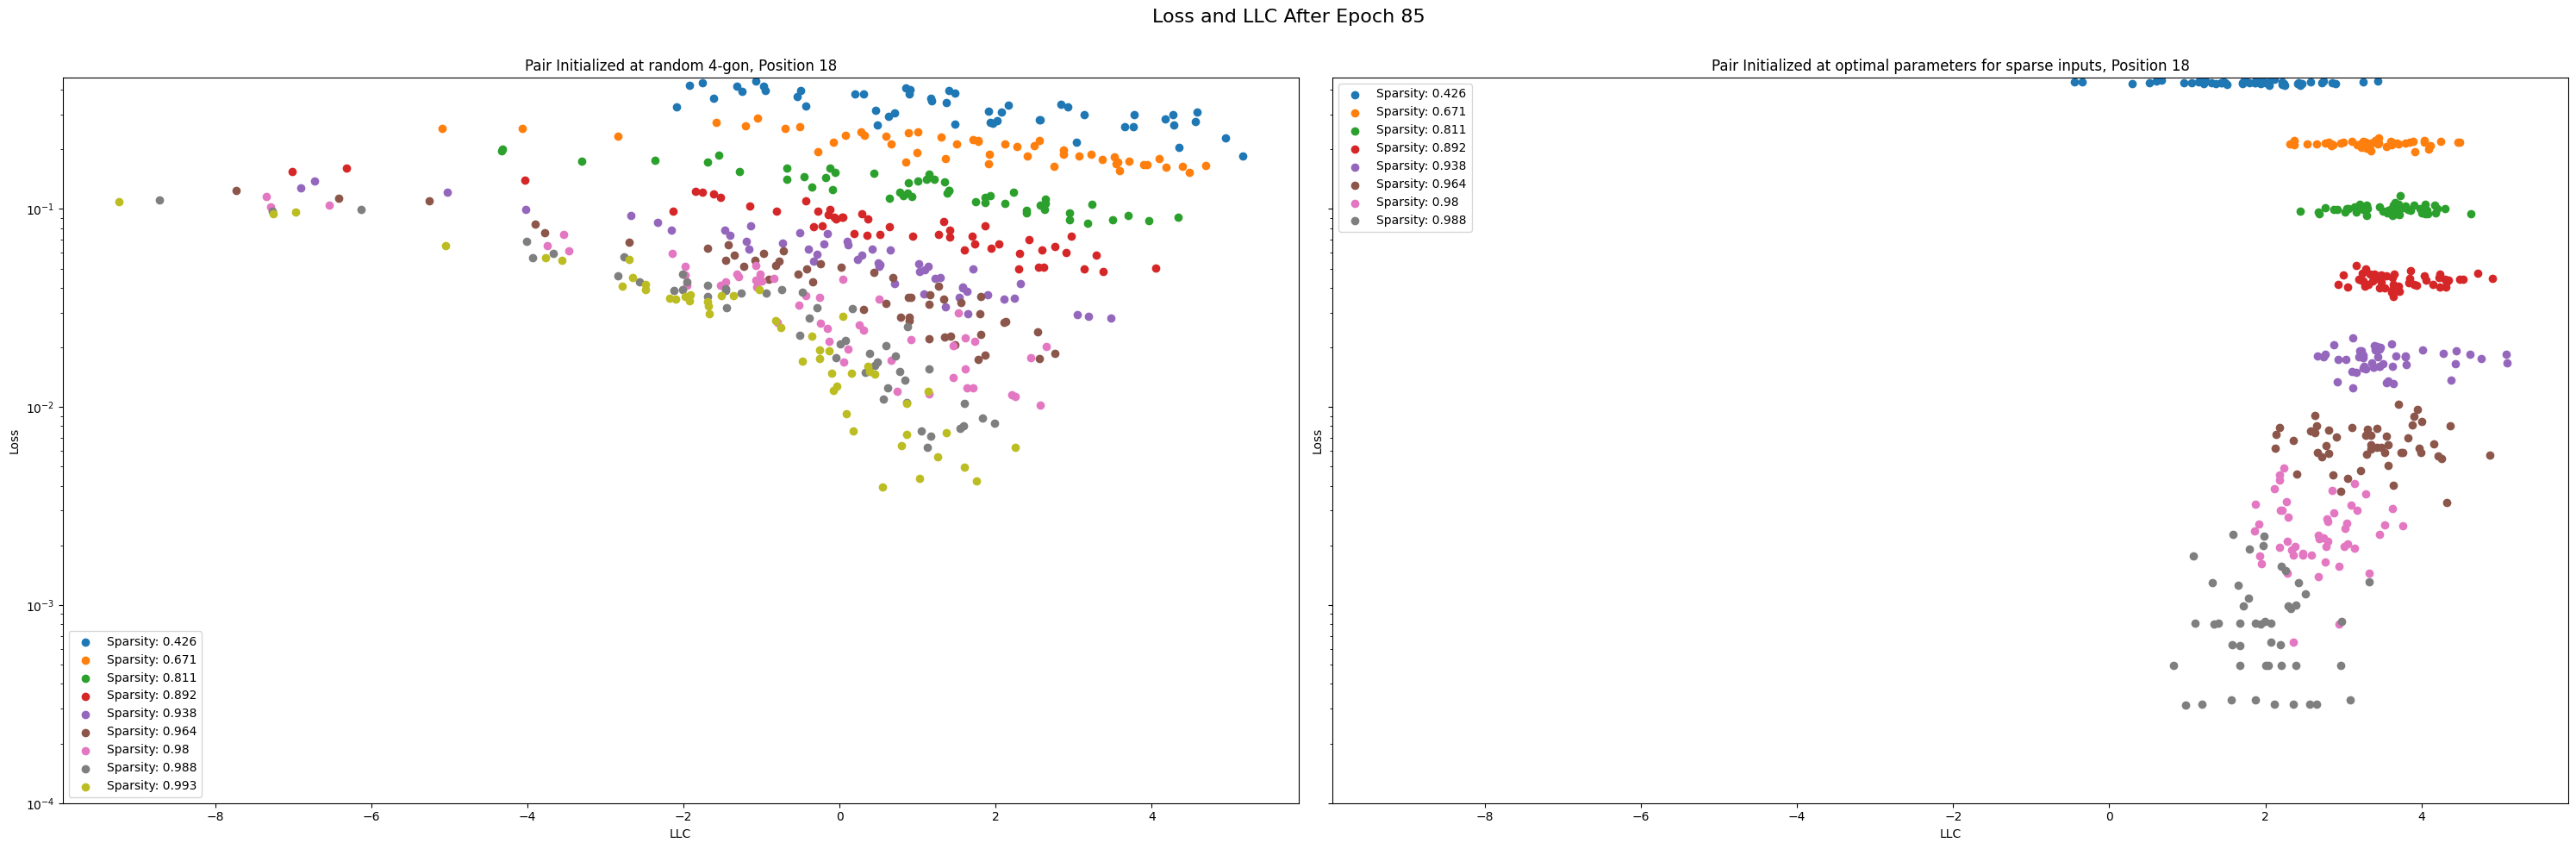

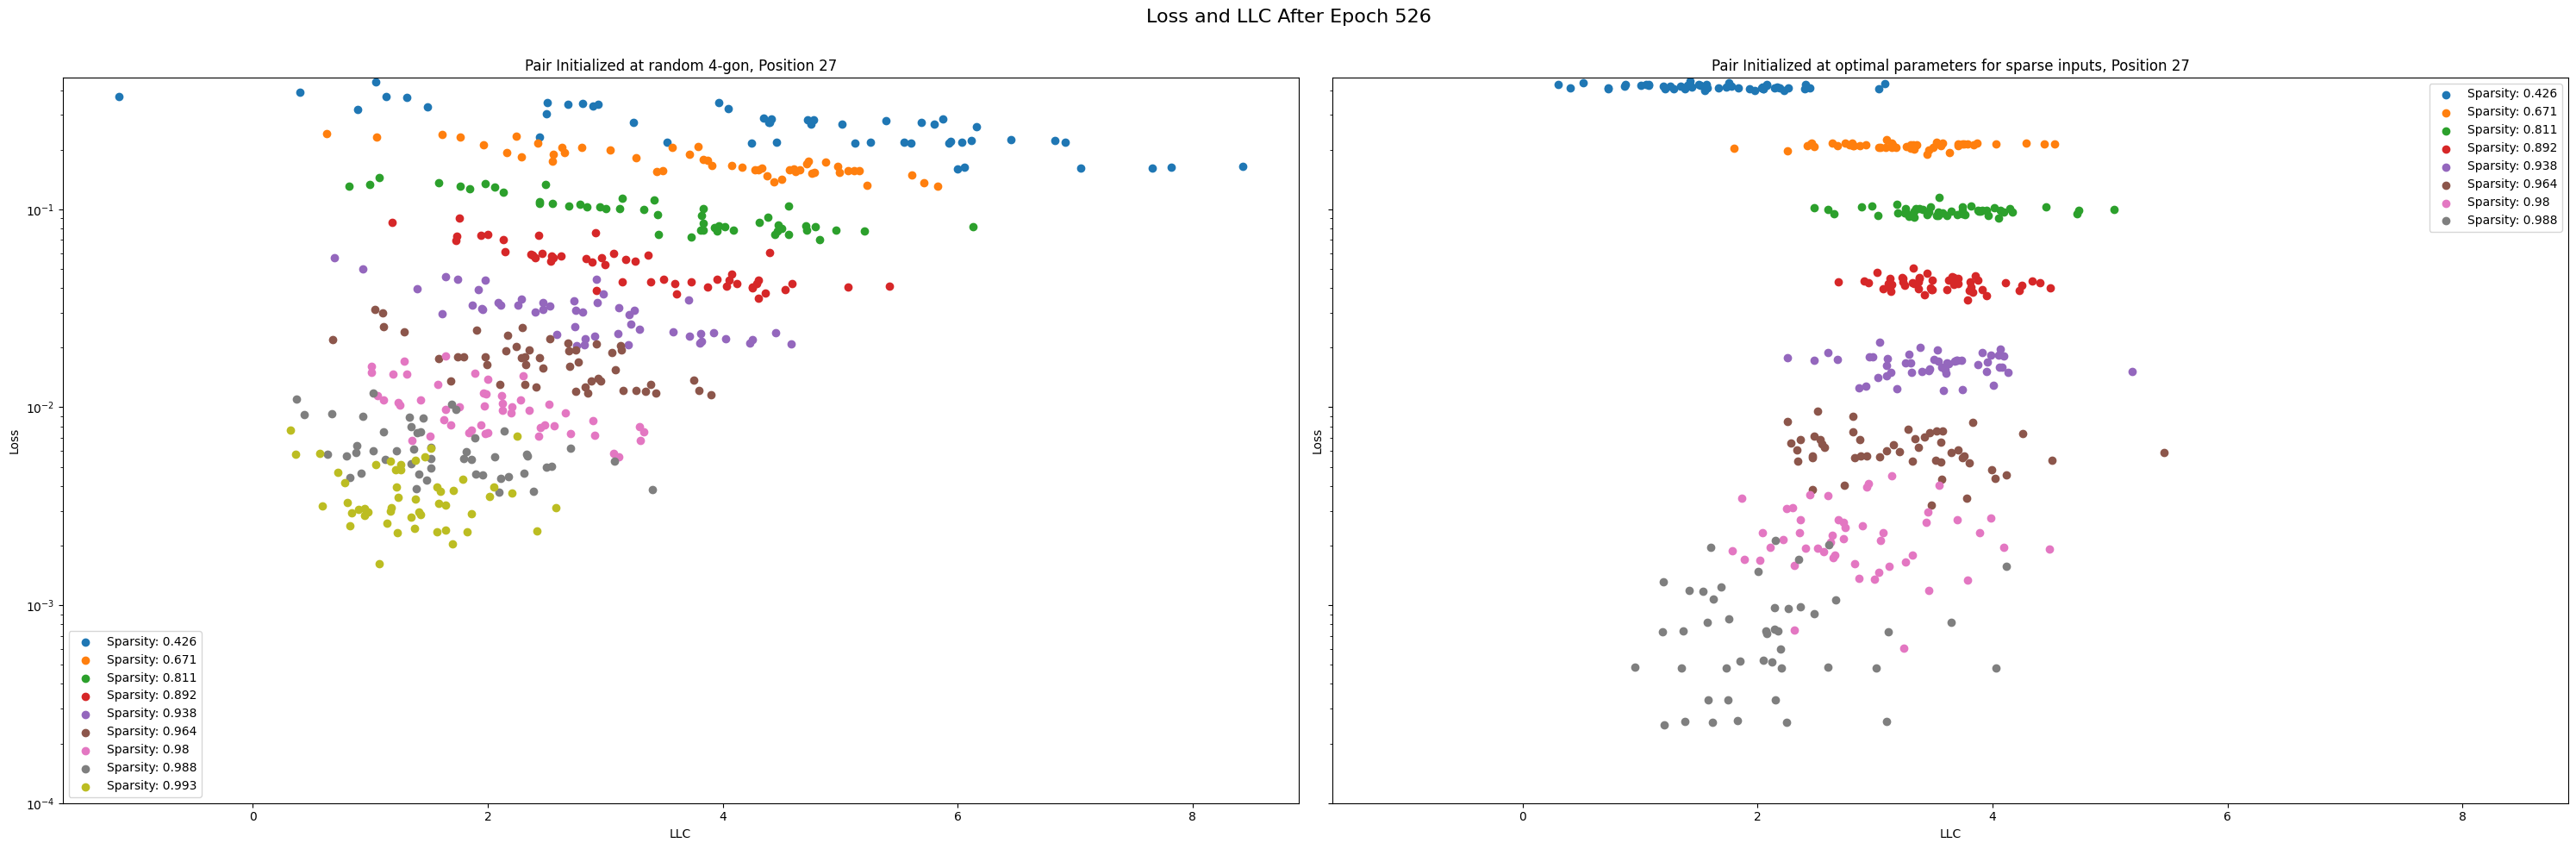

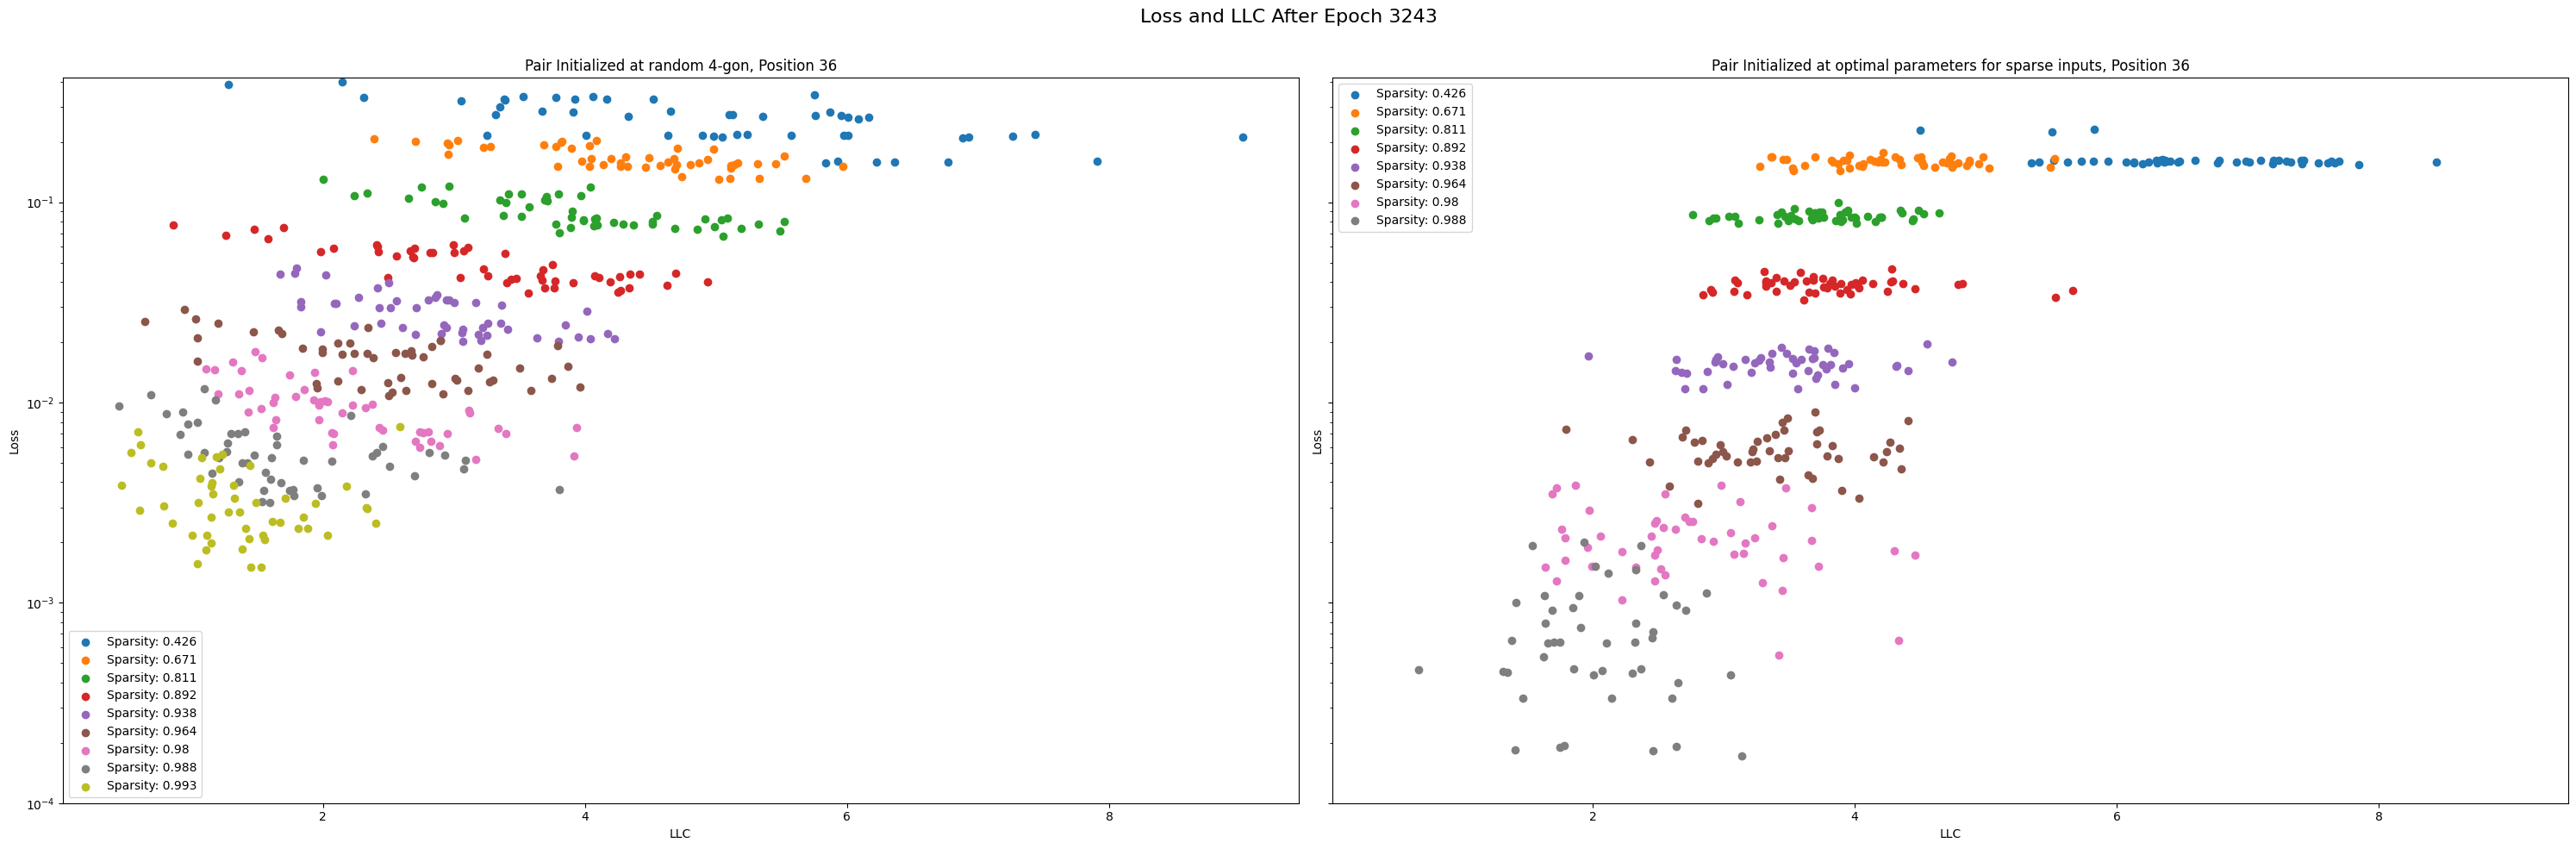

In [ ]:
compare_dataframes_and_results([(llc_estimates, results), (llc_estimates2, results2)], positions=[9, 18, 27, 36], hyperparam_combos=[(300, 0.001)], y_scale="log")

Batch size: 300, Learning rate: 0.001



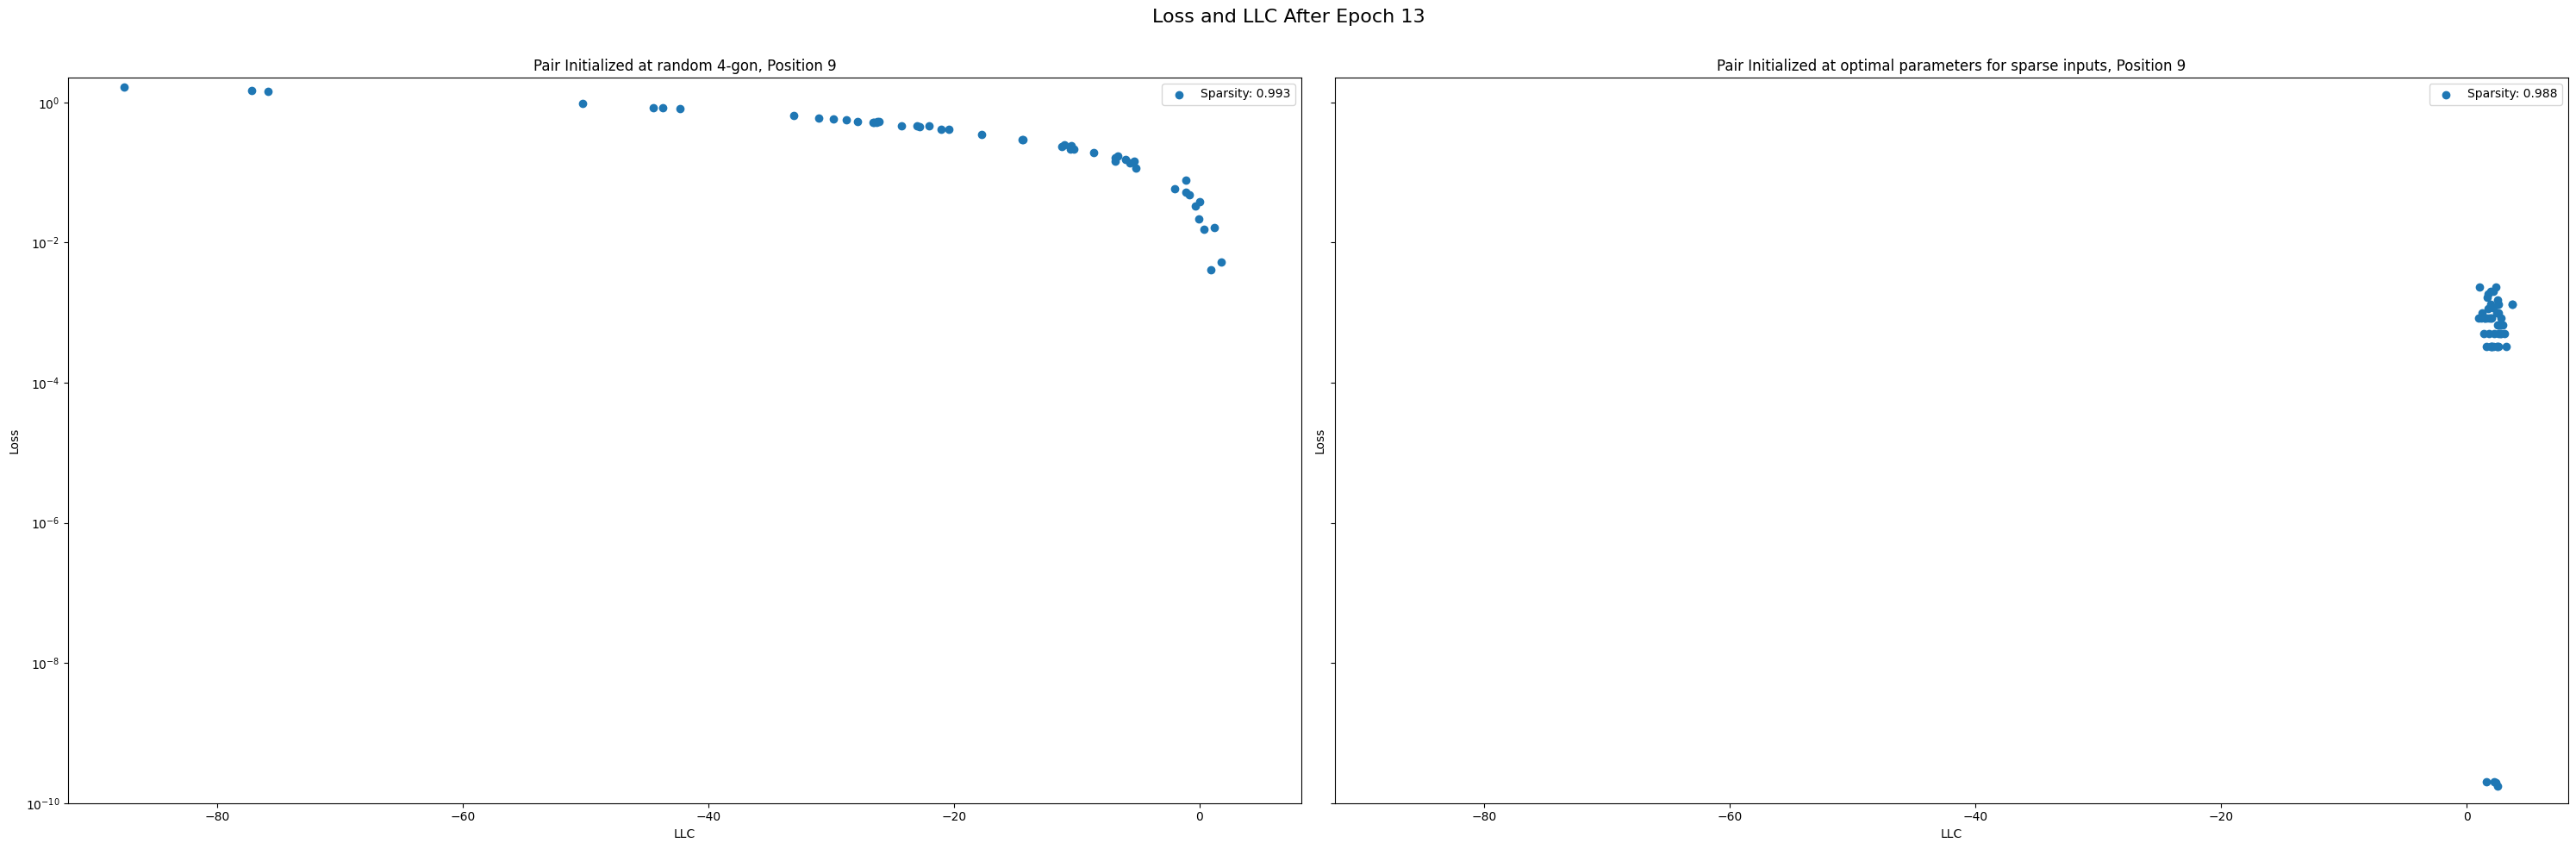

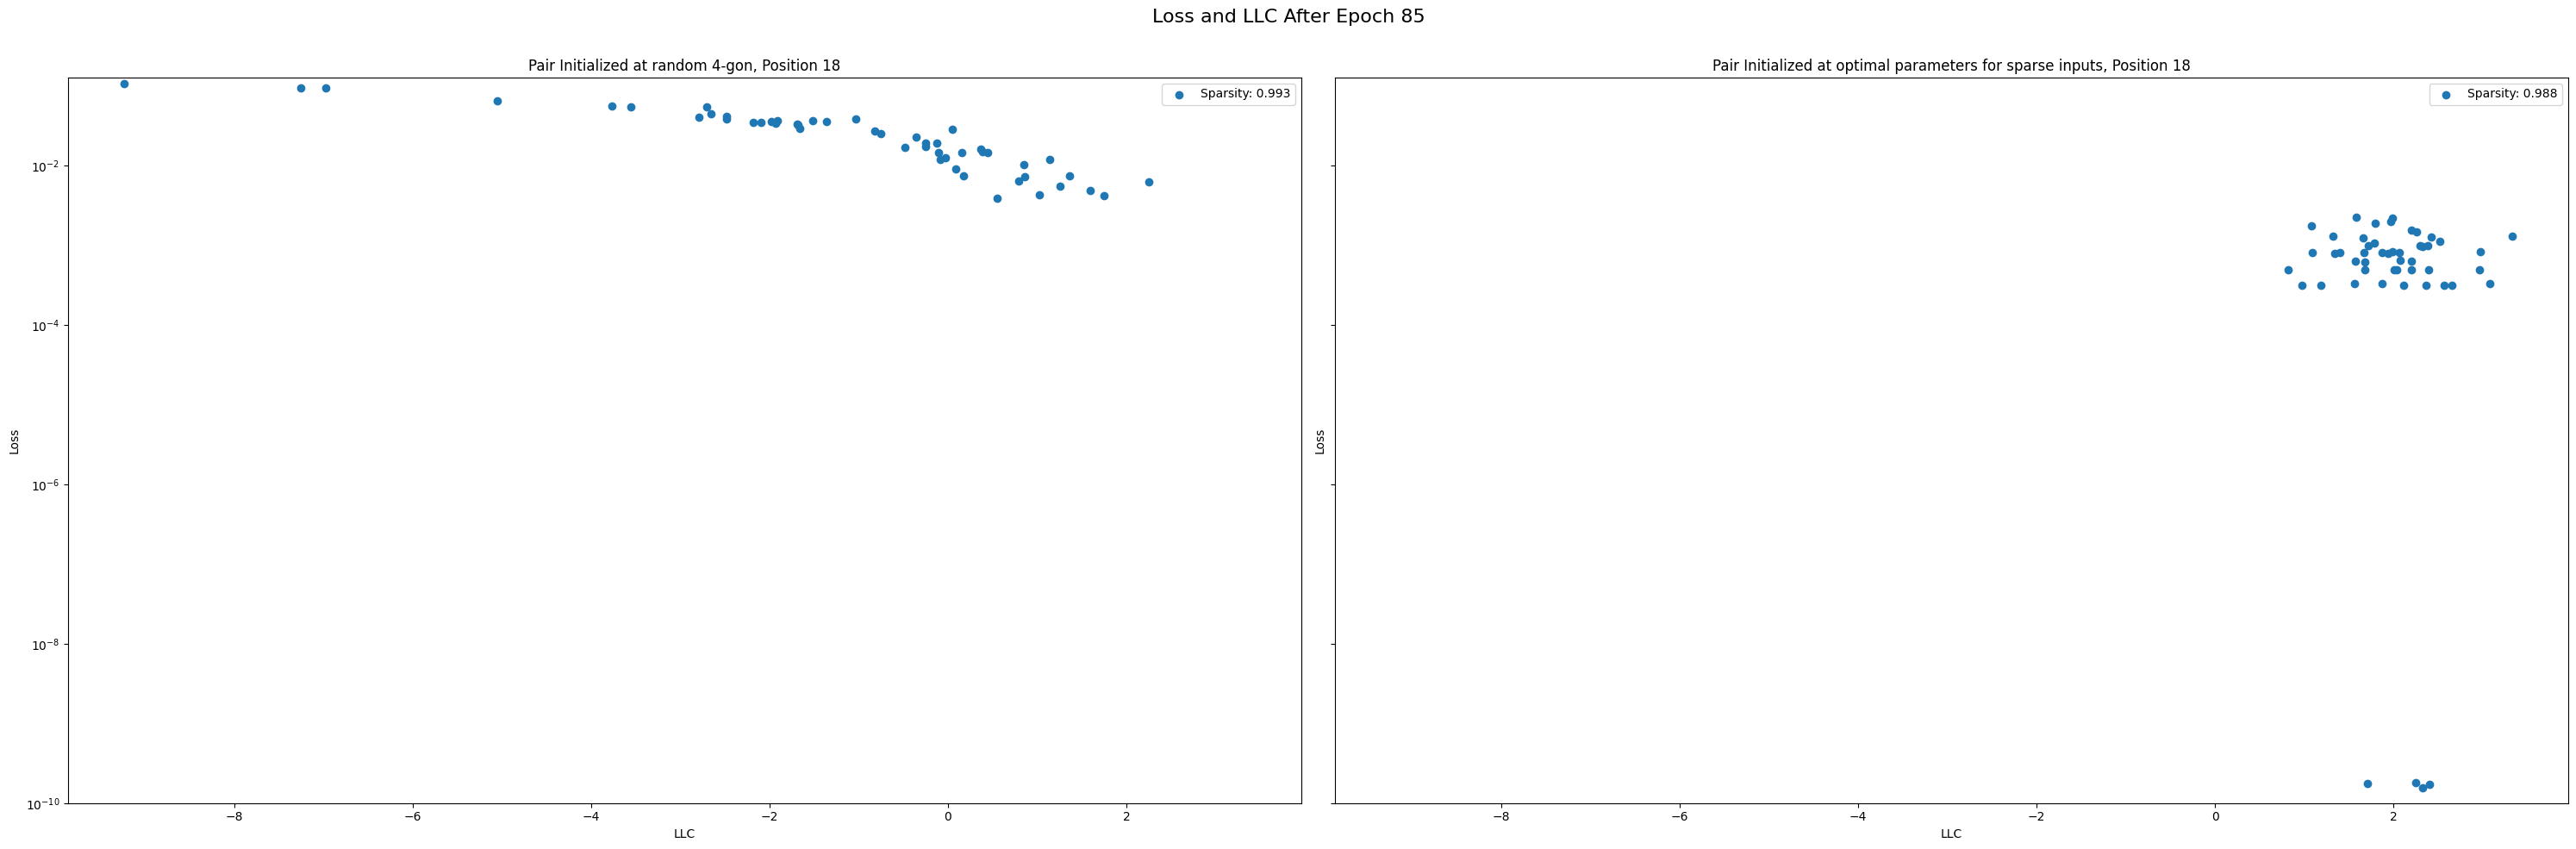

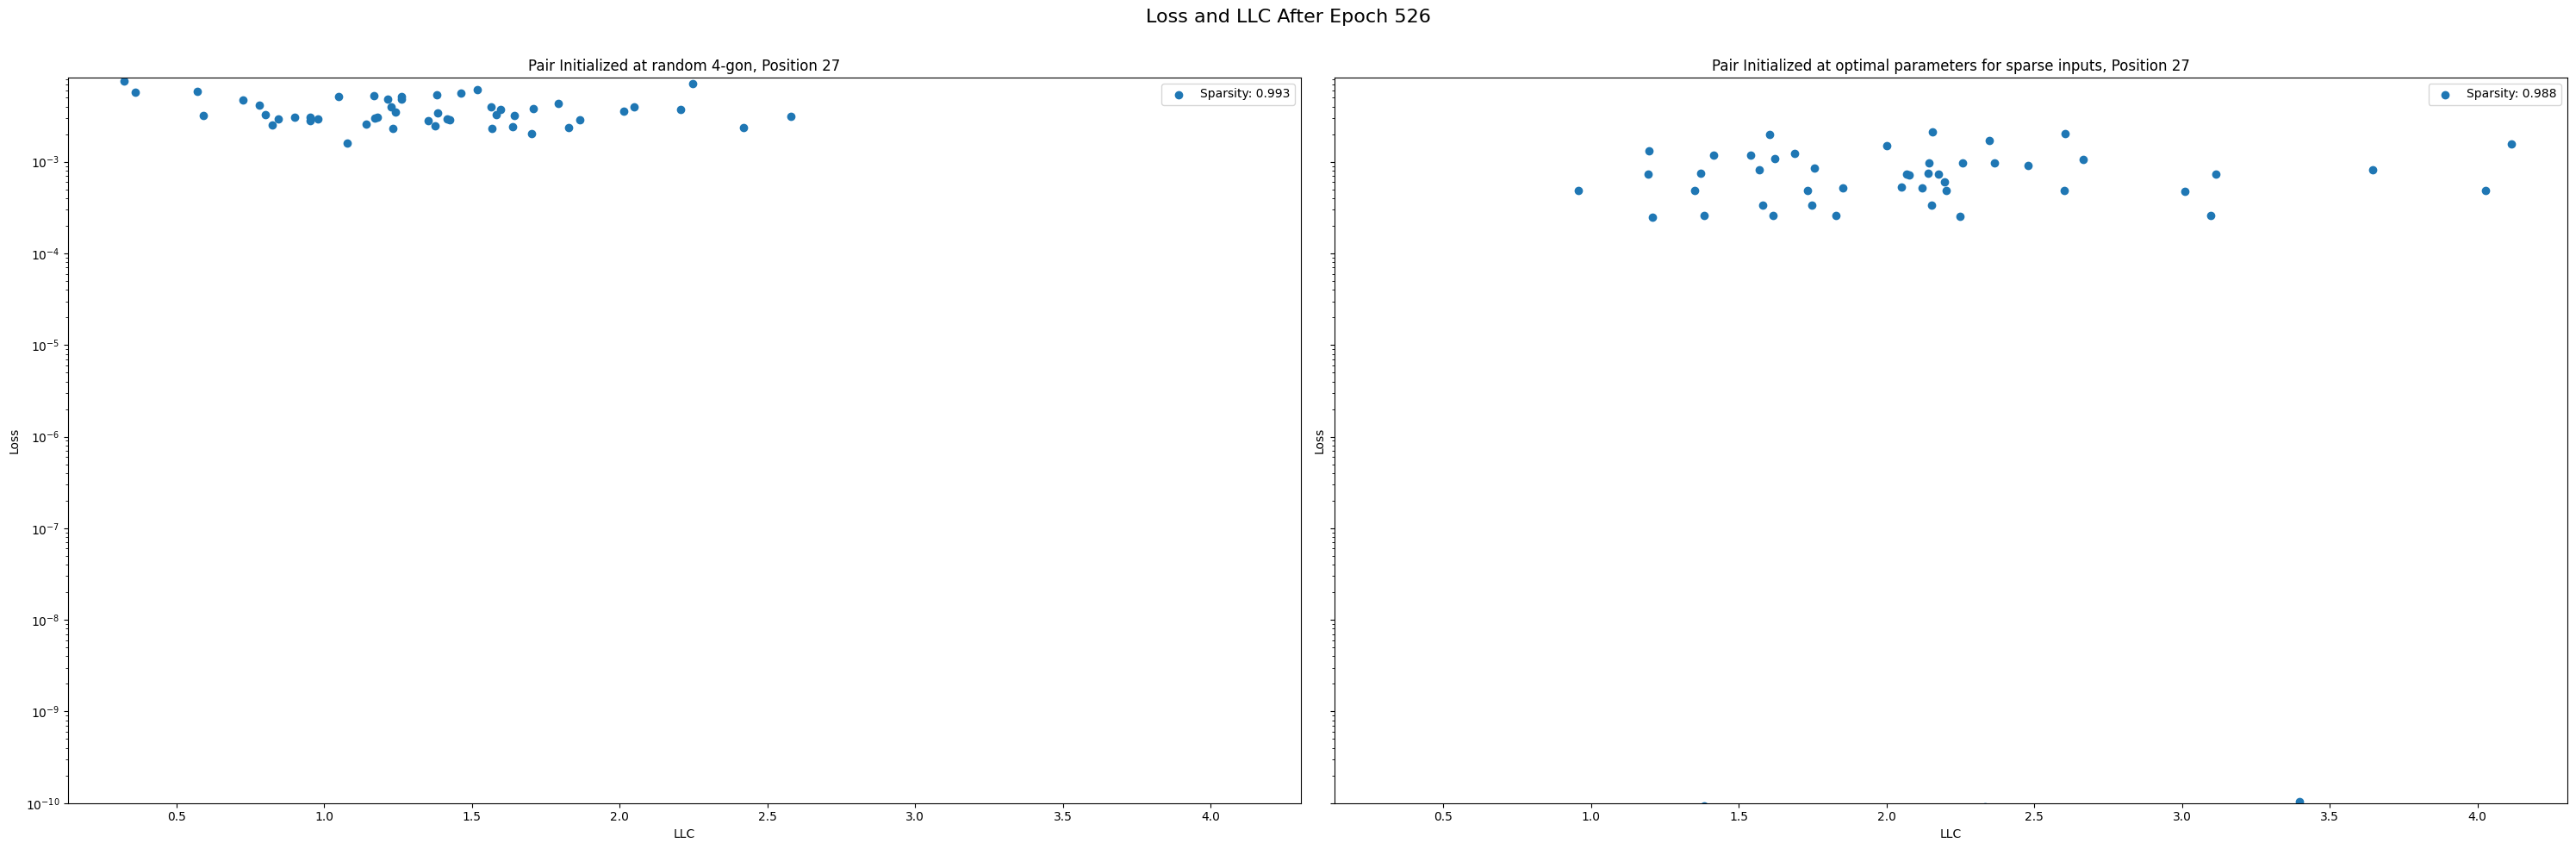

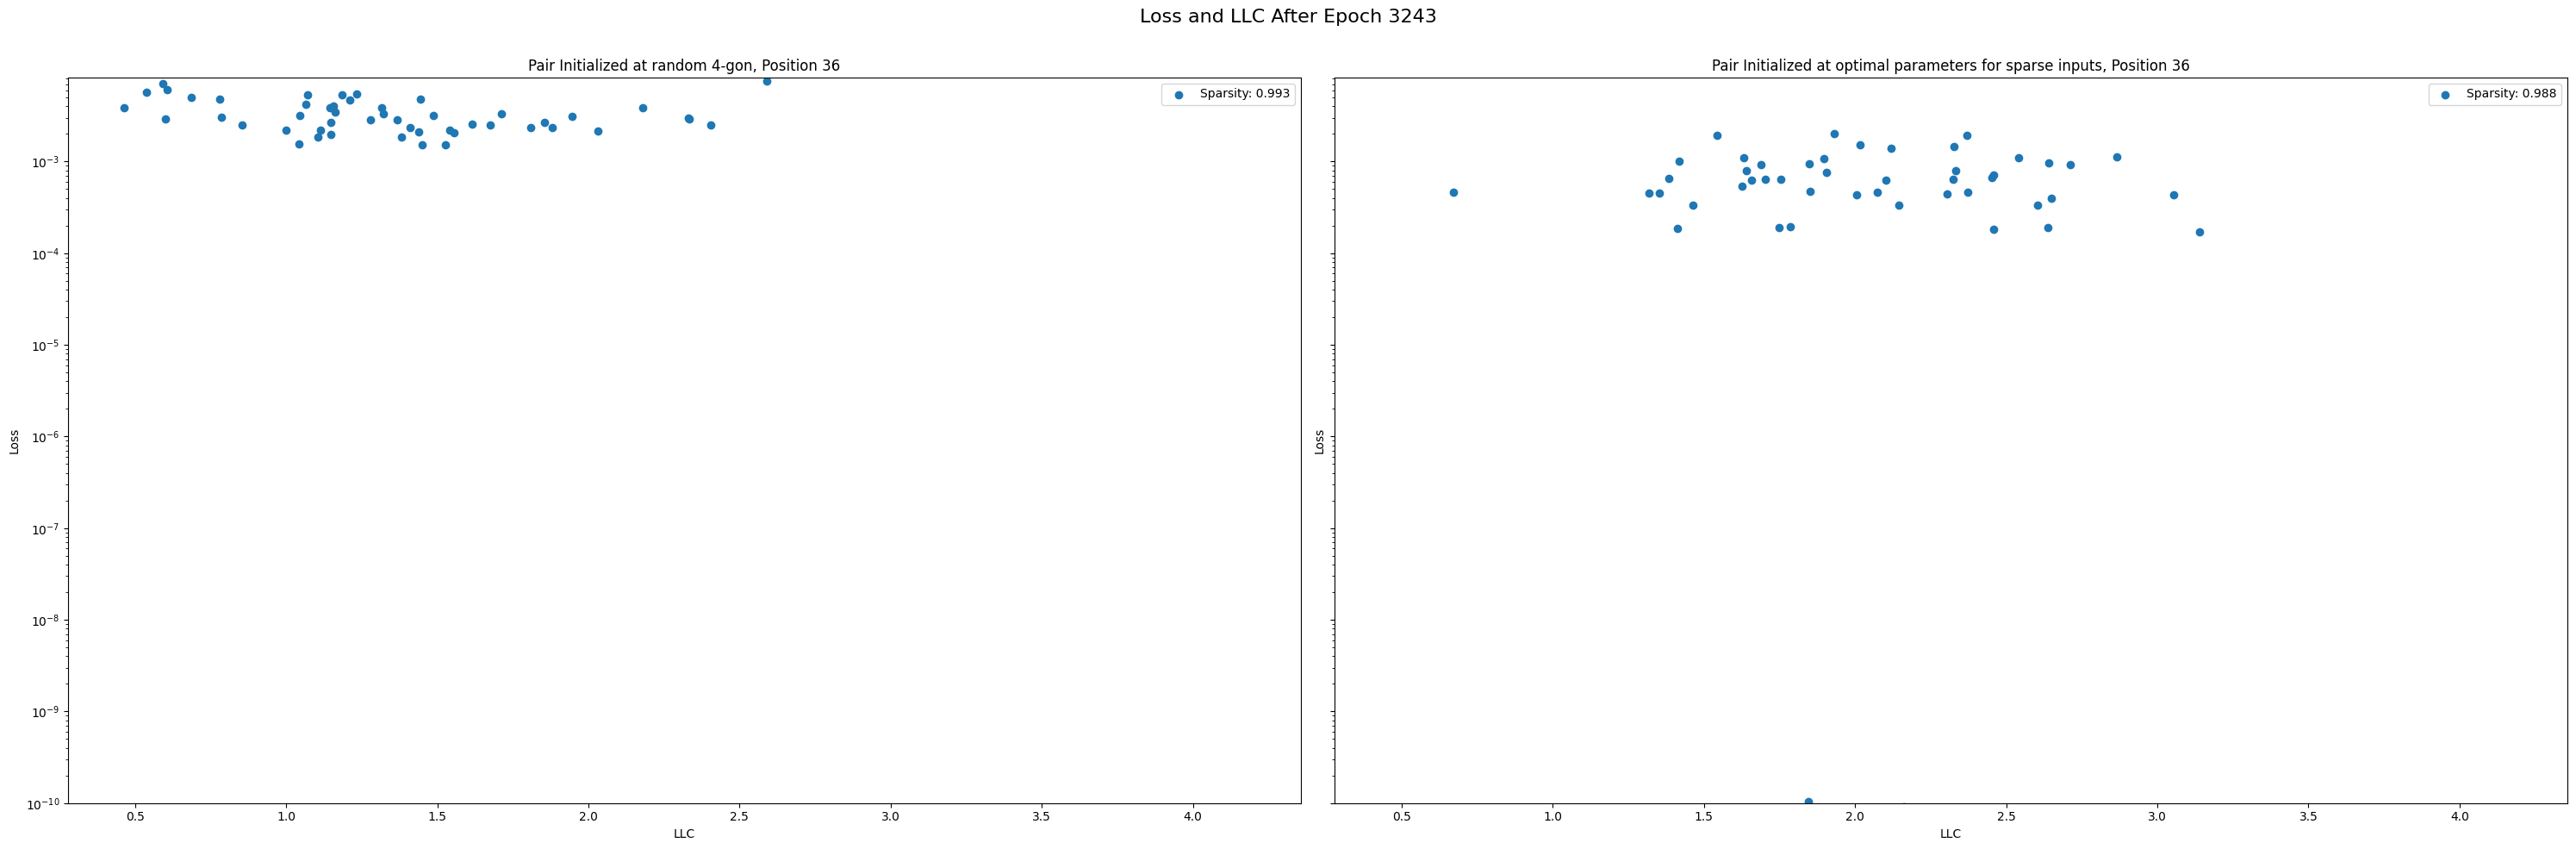

In [ ]:
compare_dataframes_and_results([(high_sparsity, results), (high_sparsity2, results2)], positions=[9, 18, 27, 36], hyperparam_combos=[(300, 0.001)], y_scale="log", sharex=True, sharey=True, ymin=0) 

In [93]:

def compare_dataframes_and_results2(df_results_pairs, positions = [9, 18, 27, 36, -1], hyperparam_combos = [(300, 0.001)], x_scale="linear", y_scale="linear", sharey=False, sharex=False, ymin=1e-4, xmin=-50):
    warnings.simplefilter(action='ignore', category=UserWarning)  # Probably unwise

    for batch_size, learning_rate in hyperparam_combos:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}\n")
        
        fig, axes = plt.subplots(len(positions), len(df_results_pairs), figsize=(15*len(df_results_pairs), 6* len(positions)), sharey=sharey, sharex=sharex)
        for i, position in enumerate(positions):
            # fig, axes = plt.subplots(1, len(df_results_pairs), figsize=(15*len(df_results_pairs), 10), sharey=sharey, sharex=sharex)
            if len(df_results_pairs) == 1:
                axes = [axes]

            for pair_index, (llc_estimates, results) in enumerate(df_results_pairs):
                llc_loss_by_sparsity = defaultdict(list)
                steps = results[0]['parameters']['log_ivl']
                
                for index in range(len(results)):
                    filtered_df = llc_estimates[llc_estimates['index'] == index]
                    llc = filtered_df[
                        (filtered_df['batch_size'] == batch_size) &
                        (filtered_df['lr'] == learning_rate) &
                        (filtered_df['snapshot_index'] == position) &
                        (filtered_df['t_sgld'] > 150) &
                        (filtered_df['llc_type'] != "mean")
                    ]["llc"].mean()
                    
                    loss = results[index]['logs']['loss'].values[position]
                    sparsity = results[index]['parameters']['sparsity']
                    llc_loss_by_sparsity[sparsity].append((llc, loss))

                for sparsity, llc_loss in llc_loss_by_sparsity.items():
                    if sparsity == 0:
                        continue
                    llcs = [llc for llc, loss in llc_loss if not(np.isnan(llc))]
                    losses = [loss for llc, loss in llc_loss if not(np.isnan(llc))]
                    if all(np.isnan(llc) for llc in llcs):
                        continue
                    axes[i,pair_index].scatter(*zip(*llc_loss), label=f"Sparsity: {round(sparsity,3)}")
                    if pair_index == 0:
                        title = "Initialized at random 4-gon"
                    if pair_index == 1:
                        title = "Initialized at optimal parameters for sparse inputs"
                    axes[i,pair_index].set_title(f"Pair {title}, Position {position}")
                    axes[i,pair_index].set_xlabel("LLC")
                    axes[i,pair_index].set_ylabel("Loss")
                    axes[i,pair_index].legend()
                    axes[i,pair_index].set_xscale(x_scale)
                    axes[i,pair_index].set_yscale(y_scale)
                    axes[i,pair_index].set_ylim(ymin=ymin)
                    axes[i,pair_index].set_xlim(xmin=xmin)


        plt.tight_layout()
        plt.suptitle(f"Loss and LLC After Epoch {steps[position]}", fontsize=16)
        plt.subplots_adjust(top=0.9)
        #plt.savefig(f'../results/loss_vs_llc_epoch_{steps[position]}')
        plt.show()

Batch size: 300, Learning rate: 0.001



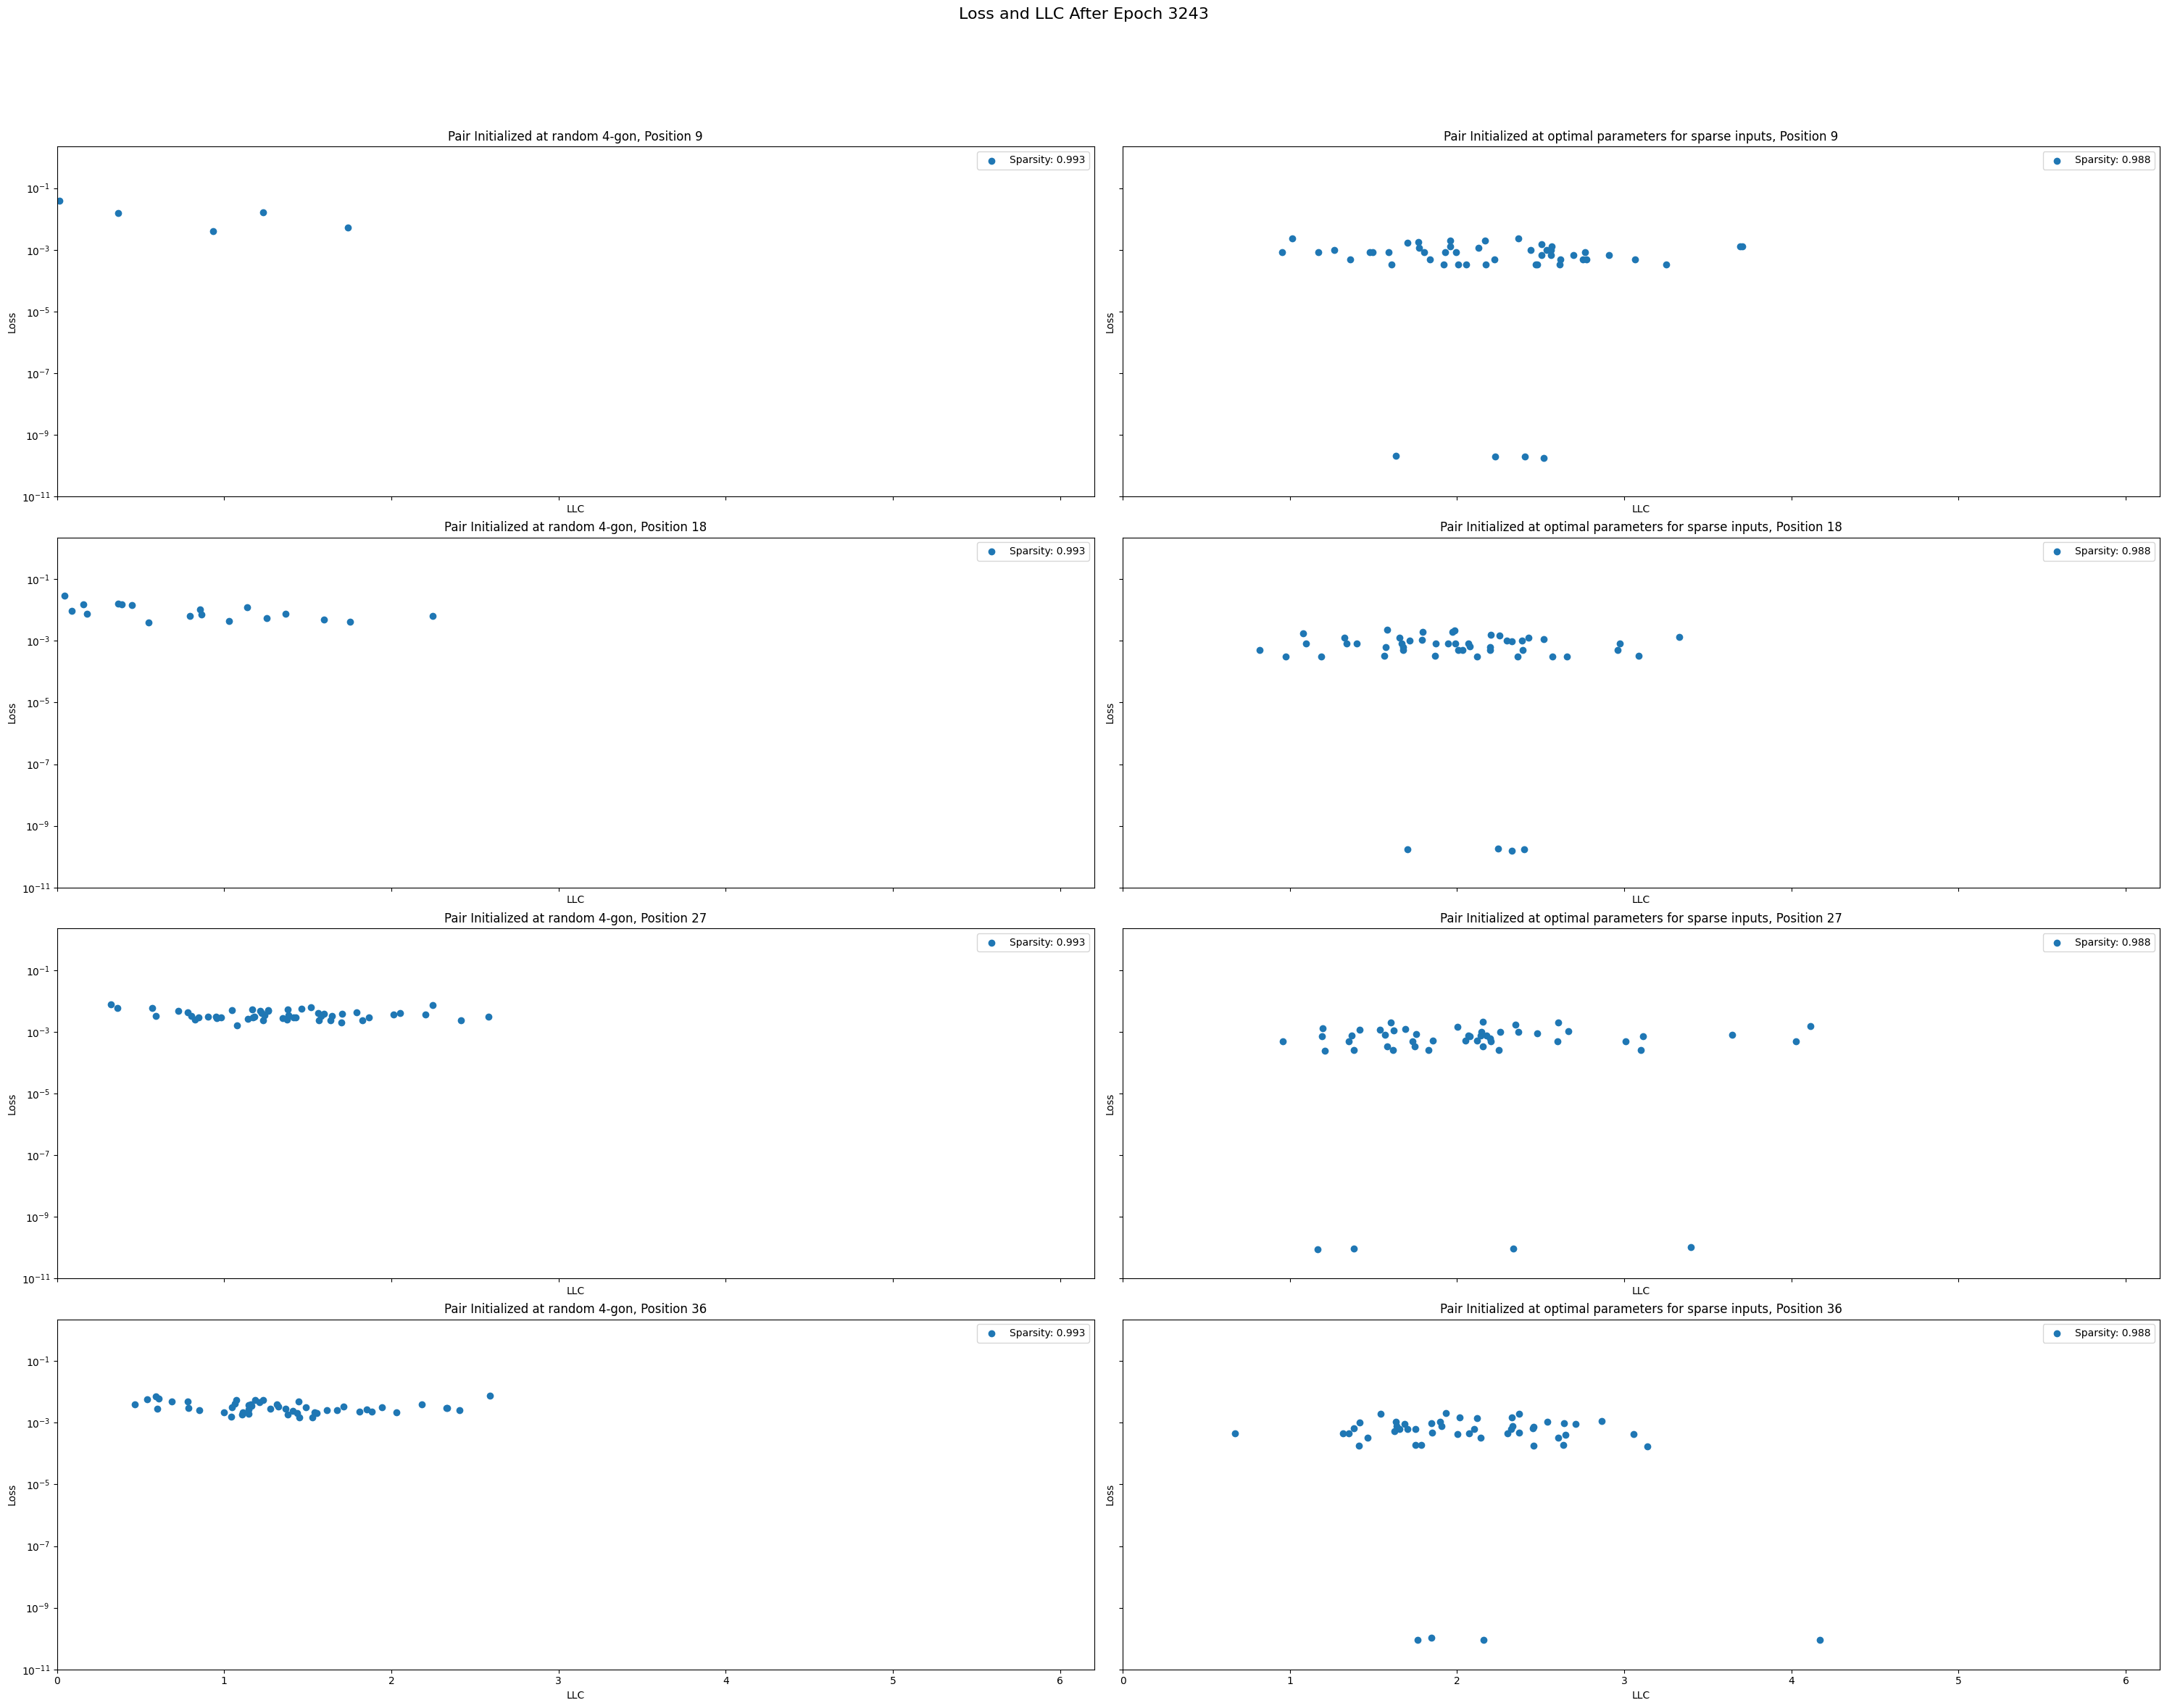

In [94]:
compare_dataframes_and_results2([(high_sparsity, results), (high_sparsity2, results2)], positions=[9, 18, 27, 36], hyperparam_combos=[(300, 0.001)], y_scale="log", sharex=True, sharey=True, ymin=1e-11, xmin=0) 